# Imports

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [112]:
data_dir = Path('data')
figures_dir = Path('figures')
output_dir = Path('outputs')

# Load Data

In [113]:
# Load data

df_anillo_1 = pd.read_csv(data_dir / 'anillo1.csv')
df_anillo_2 = pd.read_csv(data_dir / 'anillo2.csv') 

data = [df_anillo_1, df_anillo_2]

In [114]:
print(df_anillo_1.head(), "\n")
print(df_anillo_2.head(), "\n")

   Voltage [V]  Radius [mm]  Radius Error [mm]
0         4810         12.8                0.2
1         4500         13.1                0.4
2         4310         13.8                0.3
3         4100         14.2                0.4
4         3910         14.1                0.3 

   Voltage [V]  Radius [mm]  Radius Error [mm]
0         4810         22.9                0.4
1         4500         22.5                0.4
2         4310         23.4                0.4
3         4100         24.0                0.3
4         3910         24.5                0.5 



# Theory

## De Broglie Wavelength

An electron with charge $e$ accelerated through a potential difference $V$ will have a kinetic energy $K = eV$. The de Broglie wavelength of the electron is given by $\lambda = \frac{h}{p}$, where $p$ is the momentum of the electron and $h$ is the Planck constant.

The momentum of the electron is given by $p = \sqrt{2mK}$, where $m$ is the mass of the electron.

Substituting $K = eV$ into the expression for $p$, we get $p = \sqrt{2meV}$.

Substituting $p$ into the expression for $\lambda$, we get: 
$$
\lambda = \frac{h}{\sqrt{2meV}}
$$

# Data manipulation

In [115]:
# Some constants

CONST_m = 9.11e-31
CONST_e = 1.602e-19
CONST_h = 6.62e-34

In [116]:
def DeBroglie_wavelength(V, m=9.11e-31, e=1.602e-19, h=6.62e-34):
	return h / np.sqrt(2 * m * e * V)

def DeBroglie_wavelength_error(V, V_error, m=9.11e-31, e=1.602e-19, h=6.62e-34):
	return DeBroglie_wavelength(V, m, e, h) * (V_error / V)

In [117]:
def volatage_error(V):
	return 0.02 * V + 10

In [118]:
for df in data:
	df['Voltage Error [V]'] = volatage_error(df['Voltage [V]'])
	df['lambda [m]'] = DeBroglie_wavelength(df['Voltage [V]'])
	df['lambda error [m]'] = DeBroglie_wavelength_error(df['Voltage [V]'], df['Voltage Error [V]'])

In [119]:
def col_to_m(df, col_mm, col_m):
	df[col_m] = df[col_mm] / 1000



for df in data:
	col_to_m(df, 'Radius [mm]', 'Radius [m]')
	col_to_m(df, 'Radius Error [mm]', 'Radius Error [m]')

# Plotting

## Radius vs WaveLength

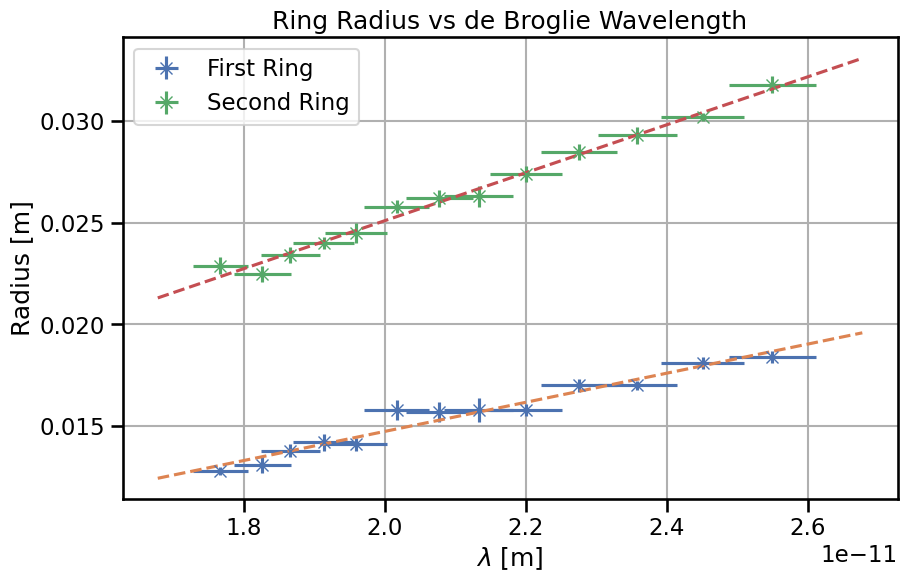

In [120]:
# Regression lines
from scipy.stats import linregress

results_1 = linregress(df_anillo_1['lambda [m]'], df_anillo_1['Radius [m]'])
results_2 = linregress(df_anillo_2['lambda [m]'], df_anillo_2['Radius [m]'])

x = np.linspace(df_anillo_1['lambda [m]'].min()*0.95, df_anillo_1['lambda [m]'].max()*1.05, 100)

plt.figure(figsize=(10, 6))

sns.set_style()
sns.set_context('talk')
sns.set_palette('deep')

plt.errorbar(df_anillo_1['lambda [m]'], df_anillo_1['Radius [m]'], yerr=df_anillo_1['Radius Error [m]'], xerr=df_anillo_1['lambda error [m]'], fmt='x', label='First Ring')
plt.plot(x, results_1.intercept + results_1.slope * x, '--')

plt.errorbar(df_anillo_2['lambda [m]'], df_anillo_2['Radius [m]'], yerr=df_anillo_2['Radius Error [m]'], xerr=df_anillo_2['lambda error [m]'], fmt='x', label='Second Ring')
plt.plot(x, results_2.intercept + results_2.slope * x, '--')


# plt.plot(df_anillo_1['lambda [m]'], df_anillo_1['Radius [m]'], 'x', label='Anillo 1')
# plt.plot(df_anillo_2['lambda [m]'], df_anillo_2['Radius [m]'], 'x', label='Anillo 2')

plt.title('Ring Radius vs de Broglie Wavelength')
plt.xlabel(r'$\lambda$ [m]')
plt.ylabel('Radius [m]')

plt.legend()
plt.grid()

plt.savefig(figures_dir / 'Radius_vs_lambda.pdf')

### Results

In [121]:
# Export results to df
results = pd.DataFrame({
	'Anillo 1': [results_1.slope, results_1.intercept, results_1.stderr, results_1.intercept_stderr, results_1.rvalue**2, results_1.pvalue],
	'Anillo 2': [results_2.slope, results_2.intercept, results_2.stderr, results_2.intercept_stderr, results_2.rvalue**2, results_2.pvalue],
}, index=['Pendiente', 'Ordenada en el origen', 'Error Pendiente', 'Error Ordenada en el origen', 'R2', 'p-valor'])

In [122]:
results.to_csv(output_dir / 'ajustes.csv')

## Radius vs Voltage

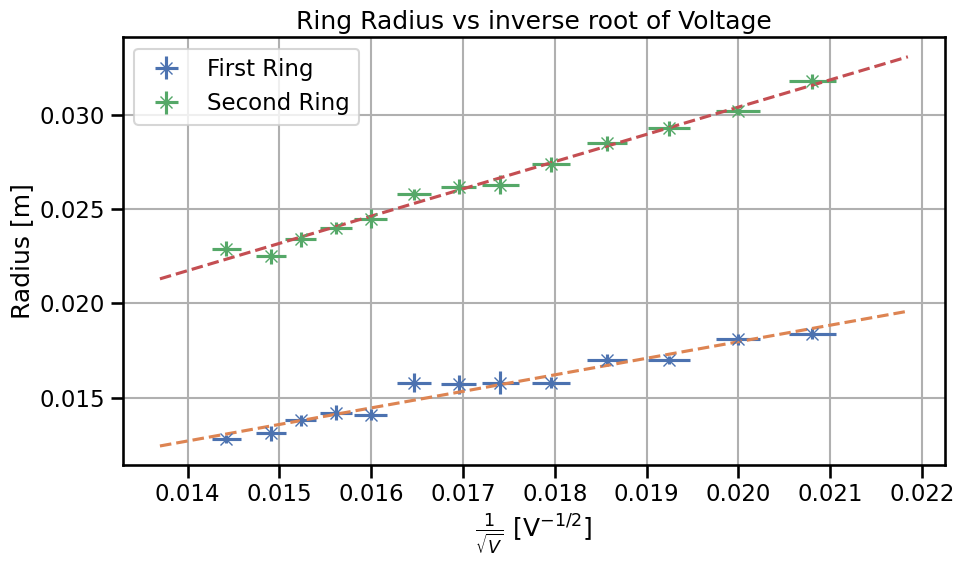

In [123]:
# Regression lines
from scipy.stats import linregress

x_exp_1 = df_anillo_1['Voltage [V]']**(-1/2)
x_exp_2 = df_anillo_2['Voltage [V]']**(-1/2)

y_exp_1 = df_anillo_1['Radius [m]']
y_exp_2 = df_anillo_2['Radius [m]']


results_V_1 = linregress(x_exp_1, y_exp_1)
results_V_2 = linregress(x_exp_2, y_exp_2)

x = np.linspace(x_exp_1.min()*0.95, x_exp_1.max()*1.05, 100)

plt.figure(figsize=(10, 6))

sns.set_style()
sns.set_context('talk')
sns.set_palette('deep')

plt.errorbar(x_exp_1, y_exp_1, yerr=df_anillo_1['Radius Error [m]'], xerr=0.5 * df_anillo_1['Voltage Error [V]'] / df_anillo_1['Voltage [V]']**1.5, fmt='x', label='First Ring')
plt.plot(x, results_V_1.intercept + results_V_1.slope * x, '--')

plt.errorbar(x_exp_2, y_exp_2, yerr=df_anillo_2['Radius Error [m]'], xerr=0.5 * df_anillo_2['Voltage Error [V]'] / df_anillo_2['Voltage [V]']**1.5, fmt='x', label='Second Ring')
plt.plot(x, results_V_2.intercept + results_V_2.slope * x, '--')


# plt.plot(df_anillo_1['lambda [m]'], df_anillo_1['Radius [m]'], 'x', label='Anillo 1')
# plt.plot(df_anillo_2['lambda [m]'], df_anillo_2['Radius [m]'], 'x', label='Anillo 2')

plt.title('Ring Radius vs inverse root of Voltage')
plt.xlabel(r'$\frac{1}{\sqrt{V}}$ [V$^{-1/2}$]')
plt.ylabel('Radius [m]')

plt.legend()
plt.grid()
plt.tight_layout()

plt.savefig(figures_dir / 'Radius_vs_inv_V.pdf')

### Results

In [124]:
results_V = pd.DataFrame({
	'Anillo 1': [results_V_1.slope, results_V_1.intercept, results_V_1.stderr, results_V_1.intercept_stderr, results_V_1.rvalue**2, results_V_1.pvalue],
	'Anillo 2': [results_V_2.slope, results_V_2.intercept, results_V_2.stderr, results_V_2.intercept_stderr, results_V_2.rvalue**2, results_V_2.pvalue],
}, index=['Pendiente', 'Ordenada en el origen', 'Error Pendiente', 'Error Ordenada en el origen', 'R2', 'p-valor'])

results_V.to_csv(output_dir / 'ajustes_V.csv')

# Calculations

## Part 1

The equation relating $r$ and $\lambda$ is given by:

$$
r = n \frac{l}{d} \lambda
$$

where $n$ is the order of the diffraction, $l$ is the distance between the screen and the diffraction grating, and $d$ is the distance between the slits in the diffraction grating.

Using the slope of the linear fit as $m$, we can write the equation as $r = m \lambda$.

Then:

$$
m = n \frac{l}{d}
$$

and

$$
d = n \frac{l}{m}
$$

In [125]:
def d_calc(n, l, slope):
	return n * l / slope 

def d_calc_error(n, l, slope, slope_error):
	return d_calc(n, l, slope) * (slope_error / slope)

In [126]:
l = 13.5e-2 # in meters
n = 1

d1 = d_calc(n, l, results_1.slope)
d1_error = d_calc_error(n, l, results_1.slope, results_1.stderr)

d2 = d_calc(n, l, results_2.slope)
d2_error = d_calc_error(n, l, results_2.slope, results_2.stderr)

print(f'd1 = {d1:.2e} m +/- {d1_error:.1e} m')
print(f'd2 = {d2:.2e} m +/- {d2_error:.1e} m')

d1 = 1.88e-10 m +/- 1.3e-11 m
d2 = 1.14e-10 m +/- 3.7e-12 m


### Chi-Square Test

In [ ]:
# Chi-squared test
from scipy.stats import chisquare

def chi_squared(observed, expected, error):
	return np.sum(((observed - expected) / error)**2)

observed_1 = df_anillo_1['Radius [m]']
expected_1 = results_1.intercept + results_1.slope * df_anillo_1['lambda [m]']
error_1 = df_anillo_1['Radius Error [m]']

observed_2 = df_anillo_2['Radius [m]']
expected_2 = results_2.intercept + results_2.slope * df_anillo_2['lambda [m]']
error_2 = df_anillo_2['Radius Error [m]']

chi_squared_1 = chi_squared(observed_1, expected_1, error_1)
chi_squared_2 = chi_squared(observed_2, expected_2, error_2)

print(f'Chi-squared for 1 = {chi_squared_1:.2f}')
print(f'Chi-squared for 2 = {chi_squared_2:.2f}')



# Critical chi-squared value
from scipy.stats import chi2
alpha = 0.05

# Degrees of freedom
df_1 = len(observed_1) - 2
df_2 = len(observed_2) - 2

criticalalue_1 = chi2.ppf(1 - alpha, df_1)
criticalalue_2 = chi2.ppf(1 - alpha, df_2)

print(f'Critical value for V_1 = {criticalalue_1:.2f}')
print(f'Critical value for V_2 = {criticalalue_2:.2f}')


Chi-squared for 1 = 14.27
Chi-squared for 2 = 9.25
Critical value for V_1 = 19.68
Critical value for V_2 = 19.68


## Part 2

Now we have $d_i$ and the slope of the linear fit, we can compute Planck's cnstant $h$ using the equation:

$$
h = \frac{m_n}{n} \frac{d}{l} \sqrt{2me}
$$

In [127]:
def h_calc(n, l, d, slope, m=9.11e-31, e=1.602e-19):
	return slope/n * d/l * np.sqrt(2 * m * e)

def h_calc_error(n, l, d, slope, slope_error, d_error):
	return h_calc(n, l, d, slope) * np.sqrt((slope_error/slope)**2 + (d_error/d)**2)

In [128]:
n = 1
l = 13.5e-2

h1 = h_calc(n, l, d1, results_V_1.slope)
h1_error = h_calc_error(n, l, d1, results_V_1.slope, results_V_1.stderr, d1_error)

h2 = h_calc(n, l, d2, results_V_2.slope)
h2_error = h_calc_error(n, l, d2, results_V_2.slope, results_V_2.stderr, d2_error)

print(f'h1 = {h1:.2e} J +/- {h1_error:.0e} J')
print(f'h2 = {h2:.2e} J +/- {h2_error:.0e} J')

h1 = 6.62e-34 J +/- 6e-35 J
h2 = 6.62e-34 J +/- 3e-35 J


### Chi-Squared Test

In [ ]:
# Chi-squared test
from scipy.stats import chisquare

def chi_squared(observed, expected, error):
	return np.sum(((observed - expected) / error)**2)

observed_V_1 = df_anillo_1['Radius [m]']
expected_V_1 = results_V_1.intercept + results_V_1.slope * x_exp_1
error_V_1 = df_anillo_1['Radius Error [m]']

observed_V_2 = df_anillo_2['Radius [m]']
expected_V_2 = results_V_2.intercept + results_V_2.slope * x_exp_2
error_V_2 = df_anillo_2['Radius Error [m]']

chi_squared_V_1 = chi_squared(observed_V_1, expected_V_1, error_V_1)
chi_squared_V_2 = chi_squared(observed_V_2, expected_V_2, error_V_2)

print(f'Chi-squared for V_1 = {chi_squared_V_1:.2f}')
print(f'Chi-squared for V_2 = {chi_squared_V_2:.2f}')


# Critical chi-squared value
from scipy.stats import chi2
alpha = 0.05

# Degrees of freedom
df_V_1 = len(observed_V_1) - 2
df_V_2 = len(observed_V_2) - 2

critical_value_V_1 = chi2.ppf(1 - alpha, df_V_1)
critical_value_V_2 = chi2.ppf(1 - alpha, df_V_2)

print(f'Critical value for V_1 = {critical_value_V_1:.2f}')
print(f'Critical value for V_2 = {critical_value_V_2:.2f}')


Chi-squared for V_1 = 14.27
Chi-squared for V_2 = 9.25
Critical value for V_1 = 19.68
Critical value for V_2 = 19.68
